In [1]:
%matplotlib inline
import sys, os
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from timeit import timeit
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from proximal import *
import pickle
%load_ext autoreload
%autoreload 2

In [115]:
def drot(init, proxf, proxg, b, max_iters=10, **kwargs):
    # Stopping parameters
    eps_abs = kwargs.pop("eps_abs", 1e-6)   
    eps_rel = kwargs.pop("eps_rel", 1e-8)   

    # Stepsize parameters
    step = kwargs.pop("step", 1.0)  
    adapt_stepsize = kwargs.pop("adapt_stepsize", True)
    incr = kwargs.pop("incr", 2.0)
    decr = kwargs.pop("decr", 2.0)
    mu = kwargs.pop("mu", 10.0)
    max_step = kwargs.pop("max_step", 1.0)
    min_step = kwargs.pop("min_step", 1e-4)

    # Overelaxation parameter
    lamda = kwargs.pop("relaxation", 1)    

    # Restart parameters
    restart = kwargs.pop("restart", True)
    adapt_restart = kwargs.pop("adapt_restart", True)

    # Printing parameters
    verbose = kwargs.pop("verbose", False)
    print_every = kwargs.pop("print_every", 1)
    compute_r_primal = kwargs.pop("compute_r_primal", False)
    compute_r_dual = kwargs.pop("compute_r_dual", False)   
    
    assert (max_step >= min_step), "Maximum stepsize must be larger than minimum one."
    assert (lamda > 0 and lamda < 2), "Relaxation parameter must be in (0,2)."

    if verbose:
        print("----------------------------------------------------")
        print(" iter | total res | primal res | dual res | time (s)")
        print("----------------------------------------------------")

    k = 0
    done = False
    y = np.array(init, order='F')
    r_primal = np.zeros(max_iters)
    r_dual = np.zeros(max_iters)
    r_full = np.infty
    r_full0 = 0.0
    m, n = y.shape
    e = np.ones(n)
    f = np.ones(m)
    if compute_r_primal:
        Az = np.zeros(b.shape)
        
    start = time()
    while not done:
        x = proxg(y)
        z = 2 * x - y
        proxf(z, step)
        x -= z # overide x by x - z 
        y -= lamda * x
        
        assert x.flags['F_CONTIGUOUS']   
        assert y.flags['F_CONTIGUOUS']   
        assert z.flags['F_CONTIGUOUS']   

        if compute_r_primal:
            Az =np.vstack((z.dot(e), z.T.dot(f)))
            r_primal[k] = nla.norm(Az - b)
        if compute_r_dual:
            r_dual[k] = nla.norm(x, ord='fro') / step
        if compute_r_primal or compute_r_dual:
            r_full = np.sqrt((r_primal[k]**2 + r_dual[k]**2))
            if k == 0: 
                r_full0 = r_full
        
        if adapt_stepsize:
            if (r_primal[k] > mu * r_dual[k]) and (step * incr <= max_step):
                step *= incr   
                print("Stepsize increased, new value is ", step) 
            elif (r_dual[k] > mu * r_primal[k]) and (step / decr >= min_step):
                step /= decr
                print("Stepsize decreased, new value is ", step)

        if (k % print_every == 0 or k == max_iters-1) and verbose:
            print("{}| {}  {}  {}  {}".format(str(k).rjust(6), 
                                        format(res, ".2e").ljust(10),
                                        format(r_primal[k], ".2e").ljust(11), 
                                        format(r_dual[k], ".2e").ljust(9),
                                        format(time() - start, ".2e").ljust(8)))
        k += 1
        done = k >= max_iters or (r_full <= eps_abs + eps_rel * r_full0)
    
    end = time()
    print("Solve time: ", end - start)
    
    return {"sol":          z, 
            "primal":       np.array(r_primal[:k]), 
            "dual":         np.array(r_dual[:k]), 
            "num_iters":    k, 
            "solve_time":   (end - start)}

In [99]:
def PDHG(init, proxg, proxh, max_iters=10, **kwargs):
    """
        min_x max_y <Ax, y> + g(x) - h(y) | x \in R^n, y \in R^m
    """
    step = kwargs.pop("step", 1.0)  
    eps_abs = kwargs.pop("eps_abs", 1e-6)   
    eps_rel = kwargs.pop("eps_rel", 1e-8)   
    lamda = kwargs.pop("relaxation", 1)
    verbose = kwargs.pop("verbose", False)
    print_every = kwargs.pop("print_every", 1)
    compute_r_primal = kwargs.pop("compute_r_primal", False)
    compute_r_dual = kwargs.pop("compute_r_dual", False)   
    adapt_stepsize = kwargs.pop("adapt_stepsize", True)
    incr = kwargs.pop("incr", 2.0)
    decr = kwargs.pop("decr", 2.0)
    mu = kwargs.pop("mu", 10.0)
    max_step = kwargs.pop("max_step", 1.0)
    min_step = kwargs.pop("min_step", 1e-4)

    assert (lamda > 0 and lamda < 2), "Relaxation parameter must be in (0,2)."

    if verbose:
        print("----------------------------------------------------")
        print(" iter | total res | primal res | dual res | time (s)")
        print("----------------------------------------------------")

    k = 0
    done = False
    x = np.array(init, order='F')
    y = np.zeros(x.shape[0] + x.shape[1])

    r_primal = np.zeros(max_iters)
    r_dual = np.zeros(max_iters)
        
    start = time()
    while not done:
        x_new = proxg(x, y, step)
        y += proxh(x, x_new, step)
        
        assert x.flags['F_CONTIGUOUS']   
        assert x_new.flags['F_CONTIGUOUS']   

        # r_primal[k] = nla.norm(x, ord=2)
        r_dual[k] = nla.norm(x_new  - x, ord='fro')
        res = np.sqrt((r_primal[k]**2 + r_dual[k]**2))

        x = x_new

        # res = 0
        if k == 0: 
            res0 = res
        
        if (k % print_every == 0 or k == max_iters-1) and verbose:
            print("{}| {}  {}  {}  {}".format(str(k).rjust(6), 
                                        format(res, ".2e").ljust(10),
                                        format(r_primal[k], ".2e").ljust(11), 
                                        format(r_dual[k], ".2e").ljust(9),
                                        format(time() - start, ".2e").ljust(8)))
        k += 1
        done = k >= max_iters or (res <= eps_abs + eps_rel * res0)
        
    end = time()
    print("Solve time: ", end - start)
    return {"sol": x, "primal": np.array(r_primal[:k]), "dual": np.array(r_dual[:k]), \
            "num_iters": k, "solve_time": (end - start)}

# Optimal transport

In [100]:
def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)

    sigma = 0.1;

    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)

    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)

    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(n):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])
    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])
    xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((n,)) / n, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()

    return n, C, p, q

Solve time:  1.9709911346435547


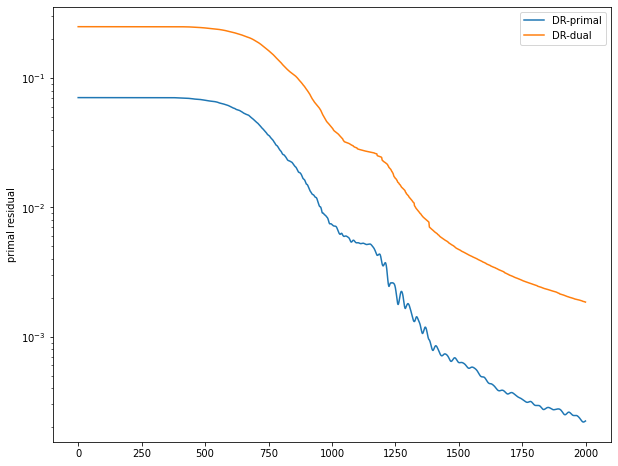

In [114]:
max_iters = 2000
step = 0.01

n, C, p, q = two_dimensional_gaussian_ot(400)
x0 = np.ones((n,n), order='F')/n

assert C.flags['F_CONTIGUOUS']   
assert x0.flags['F_CONTIGUOUS']   

proxf = lambda x, stz: trace_nonnegative_prox(x, C, stz)
proxg = lambda x: generalized_doubly_stochastic_matrices_projection(x, p, q)
proxg_ = lambda x, y, stz: primal_dual_trace_nonnegative_prox(x, C, y, stz)
proxh = lambda x, xnew, stz: primal_dual_linear_prox(x, xnew, p, q, stz)

C_ = C.copy()

drout  = drot(x0, proxf, proxg, np.vstack((p,q)), max_iters, step=step, relaxation=1.2, compute_r_primal=True,                         compute_r_dual=True, adapt_stepsize=True)
# cpout  = PDHG(x0, proxg_, proxh, max_iters, step=(1/(2*n))**0.5, relaxation=1.0)

xopt = drout["sol"]
xopt_cp = cpout["sol"]

plt.figure(1, figsize=(10,8))
plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], label='DR-primal')
plt.plot(range(drout["num_iters"]), [r for r in drout['dual']], label='DR-dual')
plt.ylabel("primal residual") 
plt.yscale('log')
plt.legend()

# plt.figure(2, figsize=(10,8))
# plt.plot(range(cpout["num_iters"]), [r for r in cpout['dual']], label='DR-dual')
# plt.ylabel("primal residual") 
# plt.yscale('log')
# plt.legend()

In [32]:
G0 = ot.emd(p, q, C_)
Gs = ot.sinkhorn(p, q, C_, 1e-3, verbose=False)
nla.norm(xopt.T - G0, ord='fro'),\
nla.norm(Gs - G0, ord='fro')

(0.03365894612042023, 0.030591086959056633)

In [33]:
np.trace(xopt.T.dot(C)), np.trace(G0.T.dot(C_)), np.trace(Gs.T.dot(C_))

(0.2602451068757028, 0.26016729117323434, 0.2610523146284066)

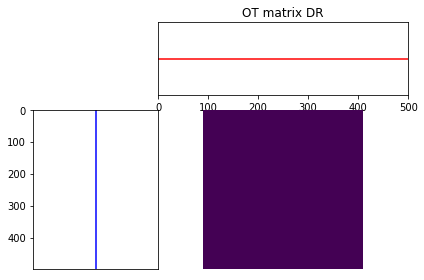

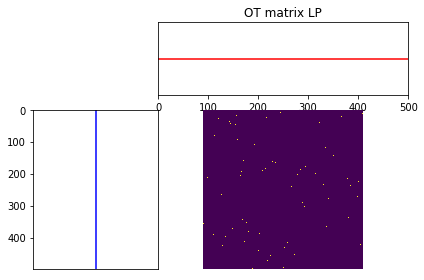

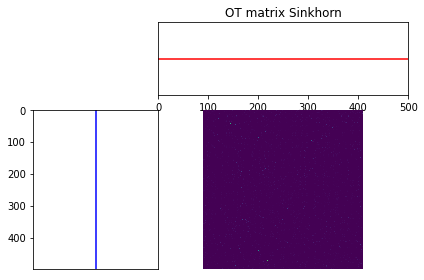

In [39]:
# G0 = ot.emd(p, q, C)

pl.figure(3, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, xopt.T, 'OT matrix DR')
# pl.title("---")

pl.figure(6, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, G0, 'OT matrix LP')

pl.figure(9, figsize=(6, 4))
ot.plot.plot1D_mat(p, q, Gs, 'OT matrix Sinkhorn')
pl.show()

Text(0.5, 1.0, 'OT matrix Sinkhorn')

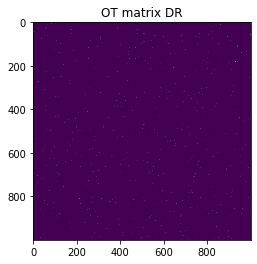

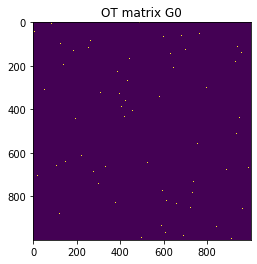

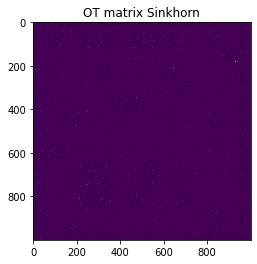

In [34]:
pl.figure(1)
pl.imshow(xopt, interpolation='nearest')
pl.title('OT matrix DR')

pl.figure(2)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(3)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix Sinkhorn')

In [47]:
import scipy
m, n = 10000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)

B = np.array(A, order='F')
assert np.allclose(A, B)

# def numpy_run1(A):
#     A_ = A.copy()
#     A_ += np.outer(x, y)

# def scipy_run(A):
#     B = np.array(A, order='F')
#     assert B.flags['F_CONTIGUOUS']
#     scipy.linalg.blas.dger(1, x, y, a=B, overwrite_a=1)

# f1 = lambda: numpy_run1(A)
# ts_md = timeit(f1, number=1)
# print(ts_md)

# f2 = lambda: scipy_run(B)
# ts_md = timeit(f2, number=1)
# print(ts_md)

# assert np.allclose(A, A_)

In [49]:
%timeit A.dot(y)

19.9 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
m, n = 5000, 5000
A = np.random.randn(m, n)
x = np.random.randn(m)
y = np.random.randn(n)
r = np.random.rand(n)
s = np.random.rand(m)
r, s = r / np.sum(r), s / np.sum(s)
e = np.ones(n)
f = np.ones(m)

B = np.array(A, order='F')
C = np.zeros((m,n))

In [407]:
f1 = lambda: projection_1(A, s, r)
ts_md = timeit(f1, number=1)
print(ts_md)

f2 = lambda: projection_2(B, s, r)
ts_md = timeit(f2, number=1)
print(ts_md)


0.40367177900043316
0.10778809300245484


In [62]:
def Sinkhorn(C, reg, a, b, delta=1e-9, lam=1e-6):

    K = np.exp(-C / reg)
    u = np.ones(np.shape(a)[0])
    v = np.ones(np.shape(b)[0])

    u_trans = np.dot(K, v) + lam  # add regularization to avoid divide 0
    v_trans = np.dot(K.T, u) + lam  # add regularization to avoid divide 0

    err_1 = np.sum(np.abs(u * u_trans - a))
    err_2 = np.sum(np.abs(v * v_trans - b))

    while True:
        if err_1 + err_2 > delta:
            u = a / u_trans
            v_trans = np.dot(K.T, u) + lam

            v = b / v_trans
            u_trans = np.dot(K, v) + lam

            err_1 = np.sum(np.abs(u * u_trans - a))
            err_2 = np.sum(np.abs(v * v_trans - b))
        else:
            return u, v


In [ ]:
# proxf_ = lambda x: nonneg_projection(x -  step * C_)
# proxg_ = lambda x: generalized_doubly_stochastic_matrices_projection_(x, p, q)